# Clusters

In this notebook, we check the cluster output sample

In [1]:
import sys
sys.path.append("/home/s1/jesteves/git/ccopa/python")
from main import copacabana
from make_input_files.make_input_datasets import *


/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using Modified sklearn.mixture.GMM, modified to allow data weights


In [2]:
import pandas as pd
from astropy.table import Table, vstack, join
from astropy.io.fits import getdata
import numpy as np
import matplotlib.pyplot as plt

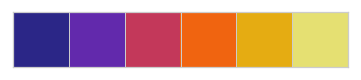

In [3]:
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.palplot(sns.color_palette("CMRmap"))

In [4]:
## colors
blue = '#2E86C1'
gray = '#A6ACAF'
red = '#A93226'

### Loading Input Catalog

In [5]:
cfg = '../config_files/config_buzzard_v2.yaml'
copa = copacabana(cfg)

run   ='testEmu'
# run   ='emuBPZ-rhod'
cat   = copa.load_copa_out('cluster',run=run)

mask= np.isnan(cat['Ngals'])
cat = cat[np.logical_not(mask)]

master file: 
 /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00000.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00001.hdf5
/data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles/buzzard_v2.0.0_copa_golden_00002.hdf5
outdir: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/
tile path: /data/des61.a/data/johnny/Buzzard/Buzzard_v2.0.0/output/tiles


In [6]:
cat.colnames

['MASKFRAC',
 'R200',
 'CID',
 'M200_true',
 'redshift',
 'Ngals',
 'DA',
 'MU',
 'tile',
 'R200_true',
 'MU_TRUE_ERR_JK',
 'magLim_i',
 'Norm',
 'RAPER',
 'Nbkg_true',
 'MU_ERR_JK',
 'MU_TRUE',
 'DEC',
 'Nbkg',
 'Ngals_true',
 'RA']

In [15]:
zcls  = cat['redshift']
r200  = cat['R200']
nbkg  = cat['Nbkg']

ngals = cat['Ngals']
mu    = cat['MU'] 
muErr = cat['MU_ERR_JK']

nbkgt = cat['Nbkg_true']
ngalst= cat['Ngals_true']
mut   = cat['MU_TRUE']
mutErr= cat['MU_TRUE_ERR_JK']

m200  = cat['M200_true']
r200t = cat['R200_true']

In [16]:
logm  = np.log10(m200)


In [17]:
sys.path.append("/home/s1/jesteves/git/ccopa/notebooks/")
from myplots import *

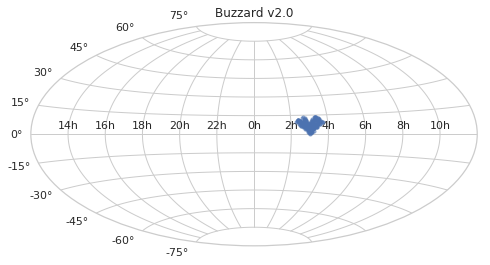

In [18]:
sky_plot(cat['RA'],cat['DEC'],title='Buzzard v2.0',savefig='sky_plot.png')

### Overall Accuracy

In [19]:
w = np.where(ngalst>1)[0]
residual = (ngals[w]/ngalst[w])
mask2    = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
mask     = remove_outliers(residual,n=2)&(mask2)

xm      = np.mean(residual[mask])
xstd    = np.std(residual[mask])

print(r'mean: %.3f'%(xm))
print(r'rms : %.3f'%(xstd))

mean: 1.018
rms : 0.238


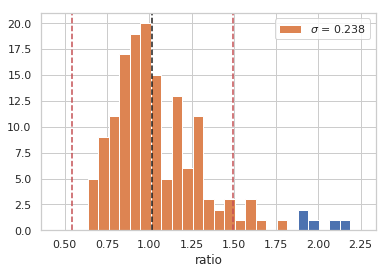

In [20]:
xmin,xmax = 0.45, 2.25
xbins = np.linspace(xmin,xmax,30)
_ = plt.hist(residual,bins=xbins)
_ = plt.hist(residual[mask],bins=xbins,label=r'$\sigma$ = %.3f'%(xstd))
plt.axvline(xm,color='k',ls='--')
plt.axvline(xm+2*xstd,color='r',ls='--')
plt.axvline(xm-2*xstd,color='r',ls='--')

#plt.yscale('log')
plt.xlabel('ratio')
plt.legend()

### Scaling Relations

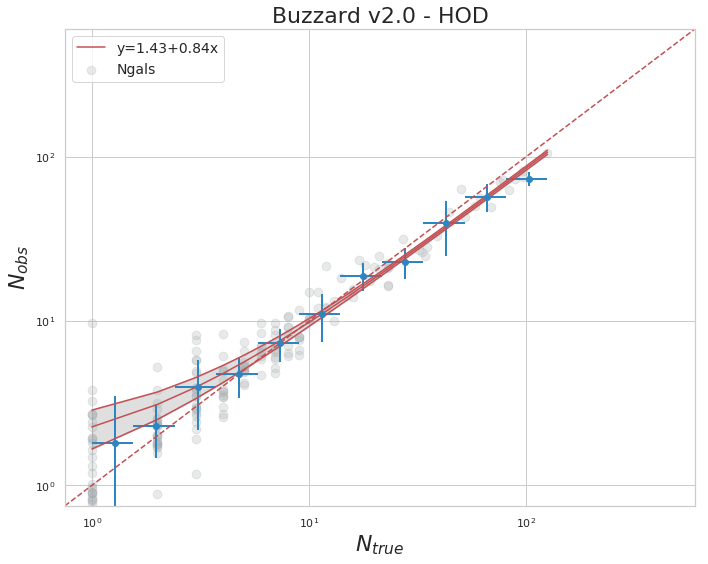

In [21]:
plot_scaling_relation(ngalst,ngals,title='Buzzard v2.0 - HOD',xlims=(0.75,600),fit=True)

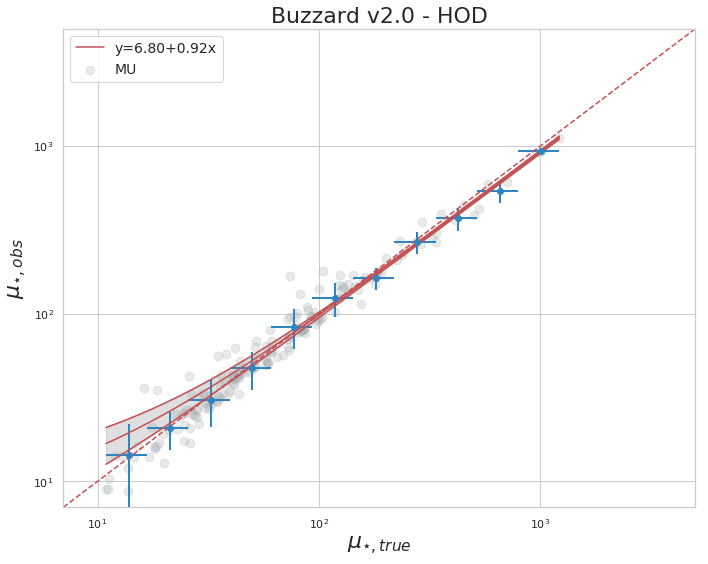

In [22]:
plot_scaling_relation(mut,mu,xl=r'$\mu_{\star,true}$',yl=r'$\mu_{\star,obs}$',title='Buzzard v2.0 - HOD',xlims=(7,5000),fit=True)

#### Residuals

myplots.py:99: RuntimeWarning: divide by zero encountered in divide
  residual = (1-yvar2/yvar1)


[0.39290316 0.30797678 0.20523577 0.24481189 0.26263247 0.23692732
 0.20872157 0.47623455 0.27979675 0.33456396]
[0.40612841 0.28380281 0.19158243 0.21396655 0.1884139  0.20411444
 0.16969097 0.17545941]
[0.30195919 0.29228201 0.28613003 0.22720535 0.28408356 0.36912839
 0.27079045 0.43543703 0.21144631 0.19329334]


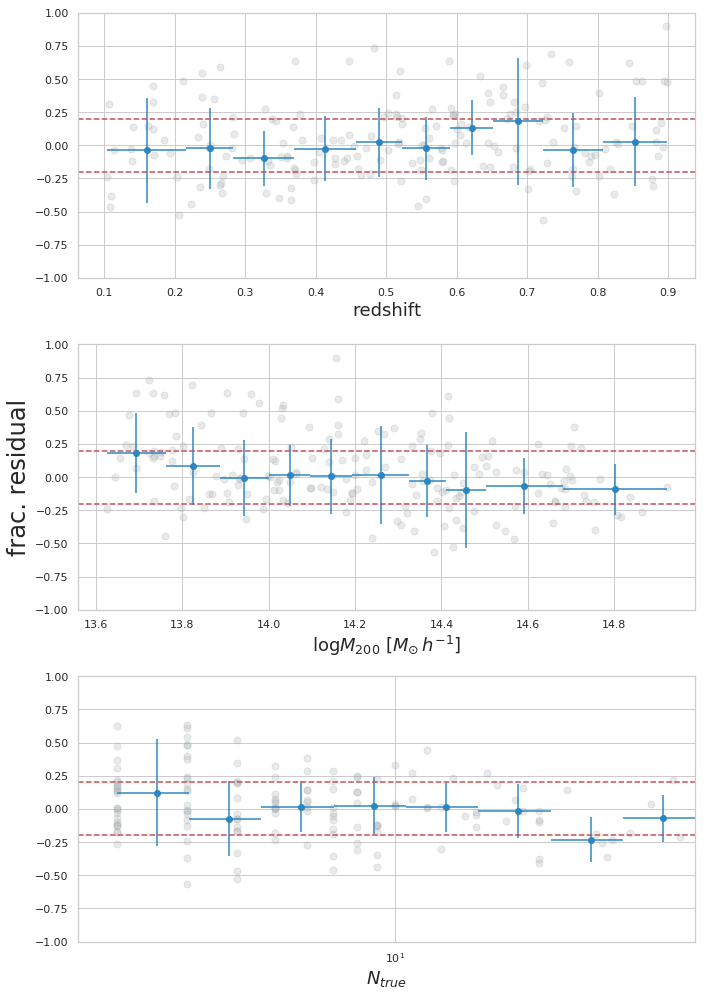

In [23]:
plot_triple_pannel(zcls,ngalst,logm,ngals,ngalst,ymax=1.,save=None)

In [24]:
def plot_residual(xvar,yvar1,yvar2, ax=None, xlabel='redshift', xbins=None,log=False):
    if ax is None: ax = plt.axes()
    
    if xbins is None:
        xbins = splitBins(xvar)
    
    residual = (1-yvar2/yvar1)
    if log:
        residual = np.log(yvar2/yvar1)
    mask2    = np.logical_not(np.isnan(residual))&np.logical_not(np.isinf(residual))
    mask     = remove_outliers(residual,n=5)&(mask2)
    if log:
        mask     = remove_outliers(residual,n=5)&(mask2)
    
    nmask    = np.logical_not(mask)
    of       = 1.-1.*np.count_nonzero(mask)/len(yvar1)
    
    keys, xvarb = makeBins(xvar[mask],xbins)
    xvarb_std = np.diff(xbins)/2
    
    residualb = np.array([np.nanmedian(residual[mask][idx]) for idx in keys])
    residualb_std = np.array([np.nanstd(residual[mask][idx]) for idx in keys])
    
    ax.scatter(xvar[nmask],residual[nmask],color='r',alpha=0.25,s=50,label='Outlier fraction: %.2f'%(of))
    ax.scatter(xvar,residual,color='#A6ACAF',alpha=0.25,s=50)
    ax.errorbar(xvarb,residualb,xerr=xvarb_std,yerr=residualb_std,color='#2E86C1',fmt='o')
    print(residualb_std)
    ax.set_xlabel(xlabel,fontsize=18)
    #ax.legend()

In [25]:
def plot_triple_pannel(zcls,ntru,logm,yvar1,yvar2,title='Residuals',save=None,ymin=-1,ymax=1.5):
    ylabel=r'frac. residual'
    ngbins = np.logspace(np.log10(2),1.*np.nanpercentile(np.log10(yvar2),95),9)
    
    fig, ax = plt.subplots(3, 1, sharey='col', figsize=(10,14))
    fig.subplots_adjust(hspace=0.4,wspace=0.6)
    
    plot_residual(zcls,yvar1,yvar2,ax=ax[0])
    plot_residual(ntru,yvar1,yvar2,ax=ax[2],xlabel=r'$N_{true}$',xbins=ngbins)
    plot_residual(logm,yvar1,yvar2,ax=ax[1],xlabel=r'$\log{M_{200}}$ [$M_{\odot}\, h^{-1}$]')

    #fig.suptitle(title,fontsize=18)

    ax[1].set_ylabel(ylabel,fontsize=24)
    ax[2].set_xscale('log')
    ax[0].set_ylim(ymin,ymax)
    ax[2].set_xlim(0.8*ngbins[0],1.*ngbins[-1])
    for i in range(3):
        ax[i].axhline(0.2,color='r',linestyle='--')
        ax[i].axhline(-0.2,color='r',linestyle='--')
    fig.tight_layout()
    
    if save:
        plt.savefig(save,bb_box='tight')
    #fig.clf()
    pass

/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1018: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/cvmfs/des.opensciencegrid.org/fnal/anaconda2/envs/des18a/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


[0.17997115 0.1927029  0.17400973 0.15309079 0.13080922 0.15392793
 0.15710851 0.2215334  0.09907975 0.17875534]
[0.20152978 0.15241038 0.18833778 0.15824103 0.13959291 0.09172861
 0.08250745        nan]
[0.16602808 0.17627459 0.15389233 0.26131841 0.12438118 0.18165369
 0.20982859 0.11018022 0.13071481 0.10657693]


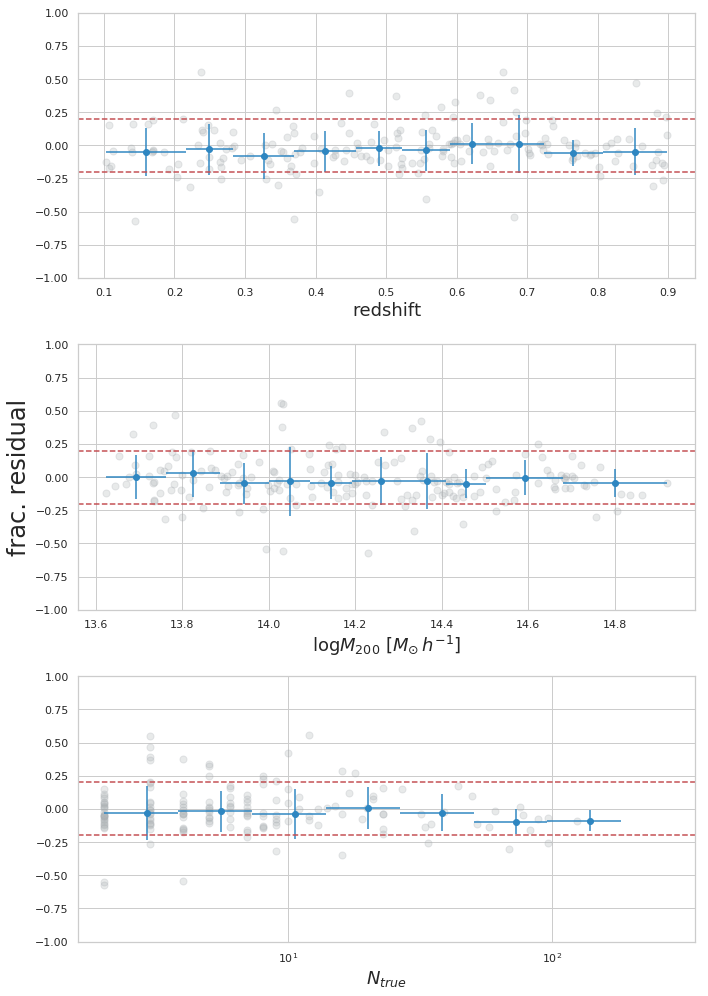

In [26]:
plot_triple_pannel(zcls,ngalst,logm,mu,mut,ymax=1.,save=None)

myplots.py:101: RuntimeWarning: divide by zero encountered in divide
  residual = np.log(yvar2/yvar1)


[0.71579888 0.67060079 0.51125803 0.95728806 0.50070135 0.94829698
 0.36491982 0.44941567 0.63671495 0.71191842]
[0.79110441 0.55896034 0.9317071  0.67961934 0.52036805 0.88416565
 0.96951088 0.34022736 0.52107013 0.34625487]
[0.78561915 0.75131367 0.7186086  0.76912283 0.84368024 0.87389501
 0.78869613 0.58658867 0.45087036 0.36240664]
[0.61258206 0.58092029 1.17407076 0.49419921 0.66251208 0.96780031
 0.69891177 0.59491215 0.52262623 0.35452149]


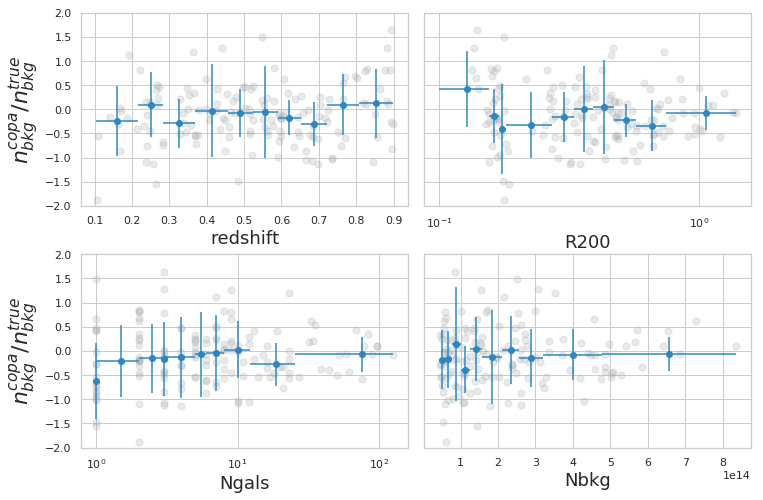

In [27]:
yl = r'$ n_{bkg}^{copa} /n_{bkg}^{true} $'
plot_four_pannel(zcls,r200,ngalst,m200,nbkgt,nbkg,ylabel=yl)

In [50]:
# def plot_four_pannel(zcls,r200,ntrue,nbkg,x1,x2,ylabel='y',ylims=(-2,2)):
#     fig, ax = plt.subplots(2, 2, sharey='all', figsize=(12,8))
#     fig.subplots_adjust(hspace=0.25,wspace=0.05)

#     ax = ax.flatten(order='F')

#     plot_residual(zcls ,x1,x2,ax=ax[0],log=True)
#     plot_residual(r200 ,x1,x2,ax=ax[2],log=True)
#     plot_residual(ntrue,x1,x2,ax=ax[1],log=True)
#     plot_residual(nbkg ,x1,x2,ax=ax[3],log=True)

#     ax[0].set_xlabel('redshift')
#     ax[1].set_xlabel('Ngals')
#     ax[2].set_xlabel('R200')
#     ax[3].set_xlabel('Nbkg')
#     ax[1].set_xscale('log')
#     ax[2].set_xscale('log')
#     ax[0].set_ylim(ylims)
#     ax[0].set_ylabel(ylabel,fontsize=22)
#     ax[1].set_ylabel(ylabel,fontsize=22)
